In [2]:
import numpy as np

from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.quantum_info import Statevector, Operator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

### Exercise $A=Y, B=2Z$

Implement a quantum circuit that performs the operation $W = Y + 2Z = \begin{pmatrix}
2 & -i \\
i & -2
\end{pmatrix}$ resulting in
$W |0\rangle = 2 |0\rangle + i |1\rangle$ with $\lambda = 3$.
If correctly implemented, when measuring the ancilla at the end of the circuit in the state 0, we performed the operation $W/\lambda = \frac{1}{3} \begin{pmatrix}
2 & -i \\
i & -2
\end{pmatrix}$.

- Print the circuit for implementing the LCU
- Print the output statevector of the circuit -- does it correctly implement $W$?
- Print the probability of success for correctly implementing the operation $W$
- Simulate measureming the circuit using the `AerSimulator` from the previous exercises / tutorials

### Solution

Construct the PREPARE circuit

In theory we have to construct the prepare circuit s.t. we have:

$$ PREP | 0 \rangle = \sqrt{\frac{2}{3}} | 0 \rangle - \sqrt{\frac{1}{3}} | 1 \rangle $$

In this case I tried to use a ry gate, the hadamard gate for a 0 vector can also be represented using a single y rotation. I then tried to evaluate the approptiate rotation angle for the y gate.


In [3]:
prep = QuantumCircuit(1, name="prep")

angle = np.arccos(1 / np.sqrt(3)) * 2

prep.ry(angle, 0)

prep = prep.to_instruction()

Construct the SELECT circuit

In [4]:
select = QuantumCircuit(2, name="select")

# YOUR CODE
select.x(0)
select.cy(0, 1)
select.x(0)

select.cz(0, 1)

select = select.to_instruction()

In [5]:
q = QuantumRegister(2,'q')
qc = QuantumCircuit(q)

#qc.x(1)  #optional to create an initial state which is |1> 
qc.append(prep, [0])
qc.barrier()

qc.append(select, [0, 1])

qc.barrier()
qc.append(prep.inverse(), [0]) # note the adjoint / dagger (`inverse()`)

In [6]:
print(qc.draw(), "\n\n")

print(qc.decompose().draw())

     ┌──────┐ ░ ┌─────────┐ ░ ┌─────────┐
q_0: ┤ prep ├─░─┤0        ├─░─┤ prep_dg ├
     └──────┘ ░ │  select │ ░ └─────────┘
q_1: ─────────░─┤1        ├─░────────────
              ░ └─────────┘ ░             


     ┌────────────┐ ░ ┌───┐     ┌───┐    ░ ┌─────────────┐
q_0: ┤ Ry(1.9106) ├─░─┤ X ├──■──┤ X ├─■──░─┤ Ry(-1.9106) ├
     └────────────┘ ░ └───┘┌─┴─┐└───┘ │  ░ └─────────────┘
q_1: ───────────────░──────┤ Y ├──────■──░────────────────
                    ░      └───┘         ░                


In [7]:
psi = Statevector(qc)
print(psi.data)
psi.draw('latex')

[0.66666667+0.j         0.47140452+0.j         0.        +0.33333333j
 0.        -0.47140452j]


<IPython.core.display.Latex object>

In [8]:
qc.measure_all()
print(qc.draw())

        ┌──────┐ ░ ┌─────────┐ ░ ┌─────────┐ ░ ┌─┐   
   q_0: ┤ prep ├─░─┤0        ├─░─┤ prep_dg ├─░─┤M├───
        └──────┘ ░ │  select │ ░ └─────────┘ ░ └╥┘┌─┐
   q_1: ─────────░─┤1        ├─░─────────────░──╫─┤M├
                 ░ └─────────┘ ░             ░  ║ └╥┘
meas: 2/════════════════════════════════════════╩══╩═
                                                0  1 


{'10': 1087, '00': 4453, '11': 2243, '01': 2217}


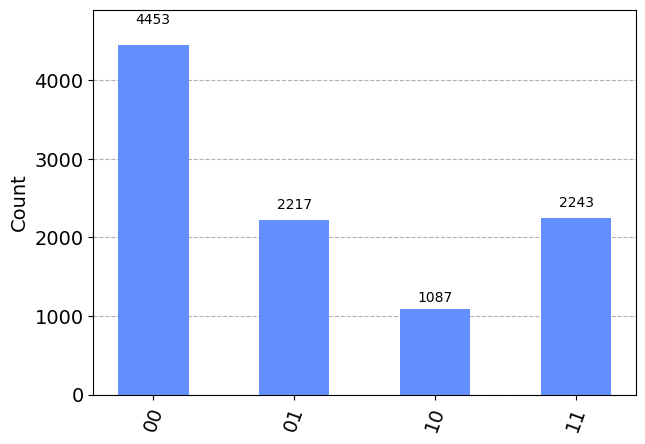

In [9]:
shots=10000

aer_sim = AerSimulator()
qc = transpile(qc, aer_sim)

result = aer_sim.run(circuits=qc, shots=shots).result()
counts = result.get_counts()
print(counts)

plot_histogram(counts)